In [1]:
import numpy as np
import pandas as pd

import sys
sys.path.append('../src/data')
sys.path.append('../src/features')
from functools import reduce

import build_features as bf
import make_dataset as md

import matplotlib.pyplot as plt
%matplotlib inline

# Sci Kit learn packages for feature transforming
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.preprocessing import Imputer

## Create a simple dataset to compare manual versus raw data with

In [2]:
originalDF = pd.read_csv("../data/raw/application_train.csv")

In [20]:
newDF = originalDF.loc[:,["SK_ID_CURR", "TARGET", "DAYS_BIRTH",
                   "AMT_INCOME_TOTAL", "DAYS_EMPLOYED", "NAME_EDUCATION_TYPE",
                   "NAME_FAMILY_STATUS", "NAME_INCOME_TYPE", "AMT_CREDIT",
                   "AMT_ANNUITY", "DAYS_EMPLOYED", "EXT_SOURCE_1",
                   "EXT_SOURCE_2", "EXT_SOURCE_3"]]

In [4]:
newDF.head()

,SK_ID_CURR,TARGET,DAYS_BIRTH,AMT_INCOME_TOTAL,DAYS_EMPLOYED,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_INCOME_TYPE,AMT_CREDIT,AMT_ANNUITY,DAYS_EMPLOYED,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3
0,100002,1,-9461,202500.0,-637,Secondary / secondary special,Single / not married,Working,406597.5,24700.5,-637,0.083037,0.262949,0.139376
1,100003,0,-16765,270000.0,-1188,Higher education,Married,State servant,1293502.5,35698.5,-1188,0.311267,0.622246,NaN
2,100004,0,-19046,67500.0,-225,Secondary / secondary special,Single / not married,Working,135000.0,6750.0,-225,NaN,0.555912,0.729567
3,100006,0,-19005,135000.0,-3039,Secondary / secondary special,Civil marriage,Working,312682.5,29686.5,-3039,NaN,0.650442,NaN
4,100007,0,-19932,121500.0,-3038,Secondary / secondary special,Single / not married,Working,513000.0,21865.5,-3038,NaN,0.322738,NaN


In [6]:
newDF.to_csv("../data/interim/application_train.csv", index = False)

## Test data pipeline

In [21]:
newDFTarget = newDF['TARGET']

In [22]:
newDF = newDF.drop(columns = ['SK_ID_CURR', 'TARGET'])

In [23]:
featureExt = Pipeline([('features', bf.DFFeatureUnion(
                transformer_list=[('numeric', Pipeline ([
                                        ('selector', bf.TypeSelector(np.number)),
                                        ('fillNaN', bf.DFImputer()),
                                        ('log', bf.LogTrans()),
                                        ('scaler', bf.DFStandardScaler())
                                        ])),
                                   ('categorical', Pipeline([
                                       ('selector', bf.TypeSelector('object')),
                                        ('concat', bf.CleanString()),
                                        ('encoder', bf.GetDummies())
                                                            ]))
                                  ]
                            ))])

In [24]:
transNewDF = featureExt.fit_transform(newDF)

In [26]:
transNewDF.head()

,DAYS_BIRTH,AMT_INCOME_TOTAL,DAYS_EMPLOYED,DAYS_EMPLOYED,AMT_CREDIT,AMT_ANNUITY,DAYS_EMPLOYED,DAYS_EMPLOYED,EXT_SOURCE_1,EXT_SOURCE_2,...,NAME_FAMILY_STATUS_Unknown,NAME_FAMILY_STATUS_Widow,NAME_INCOME_TYPE_Businessman,NAME_INCOME_TYPE_Commercialassociate,NAME_INCOME_TYPE_Maternityleave,NAME_INCOME_TYPE_Pensioner,NAME_INCOME_TYPE_Stateservant,NAME_INCOME_TYPE_Student,NAME_INCOME_TYPE_Unemployed,NAME_INCOME_TYPE_Working
0,-1.716957,0.632545,-0.790732,-0.790732,-0.216063,0.085989,-0.790732,-0.790732,-3.398625,-1.281523,...,0,0,0,0,0,0,0,0,0,1
1,0.293468,1.220963,-0.522620,-0.522620,1.402080,0.760641,-0.522620,-0.522620,-1.384610,0.574338,...,0,0,0,0,0,0,1,0,0,0
2,0.741740,-1.614519,-1.237695,-1.237695,-1.757668,-2.290346,-1.237695,-1.237695,0.046606,0.264861,...,0,0,0,0,0,0,0,0,0,1
3,0.734167,-0.196782,-0.118319,-0.118319,-0.583286,0.422813,-0.118319,-0.118319,0.046606,0.702070,...,0,0,0,0,0,0,0,0,0,1
4,0.901525,-0.412283,-0.118461,-0.118461,0.108957,-0.137338,-0.118461,-0.118461,0.046606,-0.938649,...,0,0,0,0,0,0,0,0,0,1


Need to rethink using skew test. Perphaps the new column class for scikit learn Pipeline

## Build out data pipeline

In [ ]:
newDF

In [315]:
Z = newDF[["DAYS_BIRTH", "AMT_INCOME_TOTAL", "NAME_EDUCATION_TYPE"]]

In [316]:
Z.dtypes == 'object'

DAYS_BIRTH             False
AMT_INCOME_TOTAL       False
NAME_EDUCATION_TYPE     True
dtype: bool

In [317]:
class ColumnExtractor(BaseEstimator, TransformerMixin):

    def __init__(self, cols):
        self.cols = cols

    def transform(self, X):
        Xcols = X[self.cols]
        return Xcols

    def fit(self, X, y=None):
        return self

In [318]:
class LogTrans(BaseEstimator, TransformerMixin):
    
    def __init__(self, pvalue = 1):
        self.pvalue = pvalue
    
    def transform(self, X):
        combine = zip(X, self.pvalue)
        Xtl = [np.log1p(np.absolute(X[XSeries])) if pvalues <= 0.05 else X[XSeries] for XSeries, pvalues in combine]
        return reduce(lambda X1, X2: pd.concat((X1,X2), axis = 1), Xtl)
    
    def fit(self, X, y = None):
        self.zscore, self.pvalue = skewtest(X)
        return self

In [319]:
class CleanString(BaseEstimator, TransformerMixin):
    """Cleans String"""
    def fit(self, X, y = None):
        return self

    def transform(self, X):
        assert isinstance(X, pd.DataFrame)
        return X.apply(lambda s: s.str.replace(' ', ''))

In [320]:
class GetDummies(BaseEstimator, TransformerMixin):
    def fit(self, X, y = None):
        return self
    
    def transform(self, X):
        assert isinstance(X, pd.DataFrame)
        return pd.get_dummies(X)

In [321]:
class GetColumnName(BaseEstimator, TransformerMixin):
    def fit(self, X, y = None):
        return self
    
    def transform(self, X):
        assert isinstance(X, pd.DataFrame)
        return X.column

In [322]:
class DFImputer(BaseEstimator, TransformerMixin):
    
    def __init__(self, strategy = 'mean'):
        self.strategy = strategy
        self.im = None
        self.statistics_ = None
        
    def fit(self, X, y = None):
        self.im = Imputer(missing_values='NaN', strategy=self.strategy).fit(X)
        return self
    
    def transform(self, X):
        Xim = self.im.transform(X)
        Ximputed = pd.DataFrame(Xim, index = X.index, columns = X.columns)
        return Ximputed

In [323]:
class DFStandardScaler(BaseEstimator, TransformerMixin):
    
    def __init__(self):
        self.ss = None
        
    def fit(self, X, y = None):
        self.ss = StandardScaler().fit(X)
        return self
    
    def transform(self,X):
        Xss = self.ss.transform(X)
        Xscaled = pd.DataFrame(Xss, index = X.index, columns = X.columns)
        return Xscaled

In [324]:
class DFFeatureUnion(BaseEstimator, TransformerMixin):
    
    def __init__(self, transformer_list):
        self.transformer_list = transformer_list
        
    def fit(self, X, y = None):
        for (name, t) in self.transformer_list:
            t.fit(X,y)
        return self
    
    def transform(self, X):
        Xts = [t.transform(X) for _, t in self.transformer_list]
        Xunion = reduce(lambda X1, X2: pd.merge(X1, X2, left_index = True, right_index = True), Xts)
        return Xunion
    

In [4]:
featureExt = Pipeline([('features', bf.DFFeatureUnion(
                transformer_list=[('numeric', Pipeline ([
                                        ('selector', bf.TypeSelector(np.number)),
                                        ('fillNaN', bf.DFImputer()),
                                        ('log', bf.LogTrans()),
                                        ('scaler', bf.DFStandardScaler())
                                        ])),
                                   ('categorical', Pipeline([
                                       ('selector', bf.TypeSelector('object')),
                                        ('concat', bf.CleanString()),
                                        ('encoder', bf.GetDummies())
                                                            ]))
                                  ]
                            ))])

In [5]:
transDF = featureExt.fit_transform(Z)

NameError: name 'Z' is not defined

In [327]:
Z = Z[['DAYS_BIRTH', "AMT_INCOME_TOTAL"]]
Z = np.log1p(np.absolute(Z))

In [309]:
scaler = StandardScaler()

In [310]:
scaler.fit(Z)

StandardScaler(copy=True, with_mean=True, with_std=True)

In [311]:
print(scaler.transform(Z))

[[-1.71695666  0.63254485]
 [ 0.2934677   1.22096274]
 [ 0.74174011 -1.61451934]
 ...
 [-0.10542407  0.05922287]
 [-0.8930243   0.28672063]
 [ 0.31249053  0.11851314]]


In [337]:
db = np.absolute(newDF[["DAYS_BIRTH"]])

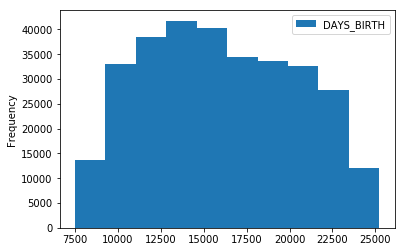

In [338]:
db.plot(kind = "hist")

In [342]:
skewtest(db)

SkewtestResult(statistic=array([26.10082825]), pvalue=array([3.56771536e-150]))

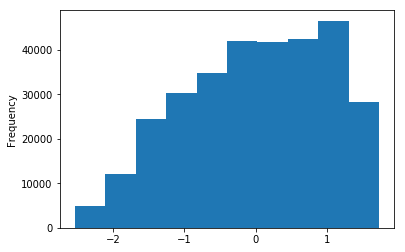

In [332]:
transDF["DAYS_BIRTH"].plot(kind = "hist")

In [30]:
model = Pipeline([('features', fu)])

In [31]:
model

Pipeline(memory=None,
     steps=[('features', FeatureUnion(n_jobs=1,
       transformer_list=[('numeric', Pipeline(memory=None,
     steps=[('selector', TypeSelector(dtype=<class 'numpy.number'>)), ('scaler', StandardScaler(copy=True, with_mean=True, with_std=True))])), ('boolean', Pipeline(memory=None, steps=[('selector', TypeSelector(dtype='bool'))])), ('categorical', Pip...', dtype=<class 'numpy.float64'>,
       handle_unknown='ignore', n_values='auto', sparse=True))]))],
       transformer_weights=None))])

In [56]:
J=Z["NAME_EDUCATION_TYPE"]

In [62]:
J.str.replace(' ', '')

0         Secondary/secondaryspecial
1                    Highereducation
2         Secondary/secondaryspecial
3         Secondary/secondaryspecial
4         Secondary/secondaryspecial
5         Secondary/secondaryspecial
6                    Highereducation
7                    Highereducation
8         Secondary/secondaryspecial
9         Secondary/secondaryspecial
10                   Highereducation
11        Secondary/secondaryspecial
12        Secondary/secondaryspecial
13        Secondary/secondaryspecial
14        Secondary/secondaryspecial
15        Secondary/secondaryspecial
16        Secondary/secondaryspecial
17        Secondary/secondaryspecial
18        Secondary/secondaryspecial
19                   Highereducation
20        Secondary/secondaryspecial
21        Secondary/secondaryspecial
22        Secondary/secondaryspecial
23        Secondary/secondaryspecial
24        Secondary/secondaryspecial
25        Secondary/secondaryspecial
26        Secondary/secondaryspecial
2

## Imputing Missing Class Values

In [32]:
import numpy as np
from sklearn.neighbors import KNeighborsClassifier

In [33]:
KN = newDF["NAME_EDUCATION_TYPE"]

In [41]:
KN.isnull().sum()

0

In [39]:
kn

array(['Secondary / secondary special', 'Higher education',
       'Secondary / secondary special', ..., 'Higher education',
       'Secondary / secondary special', 'Higher education'], dtype=object)

## Test out skew for determining when to Log fit

In [59]:
from scipy.stats  import skewtest, skew

In [36]:
sTest = newDF["AMT_INCOME_TOTAL"]

In [157]:
qTest = newDF["DAYS_BIRTH"]

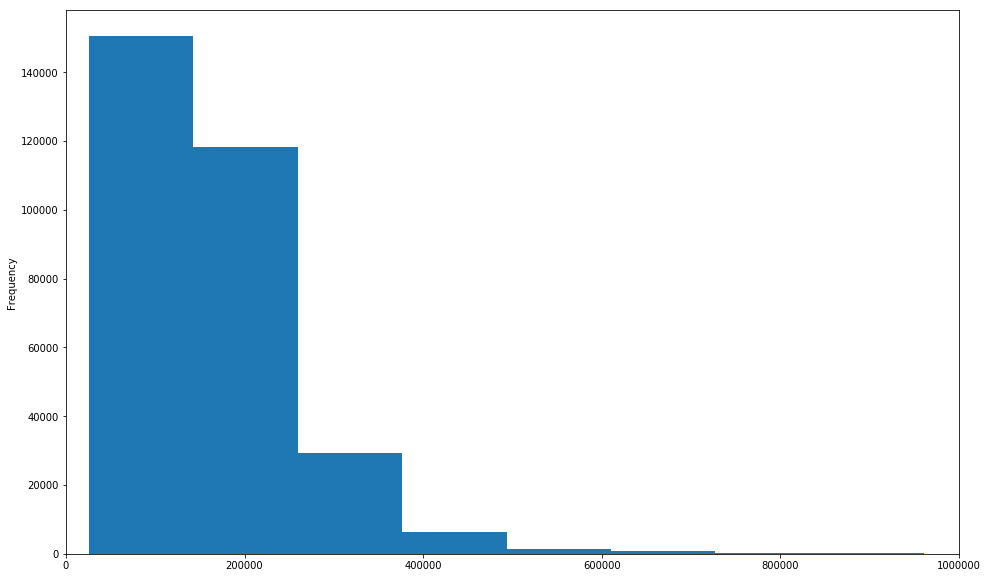

In [56]:
sTest.plot(kind = 'hist', bins = 1000, figsize = (16,10), xlim = (0, 1000000))

In [158]:
skewtest(sTest)

SkewtestResult(statistic=1269.2229361102025, pvalue=0.0)

In [159]:
skewtest(qTest)

SkewtestResult(statistic=-26.100828246519708, pvalue=3.5677153646450325e-150)

In [60]:
skew(sTest)

391.55774412283097

In [90]:
def transform(X):
    zscore, pvalue = skewtest(X)
    if pvalue <= 0.05:
        print(pvalue)
        return np.log(X) 
    else:
        return X

0.0


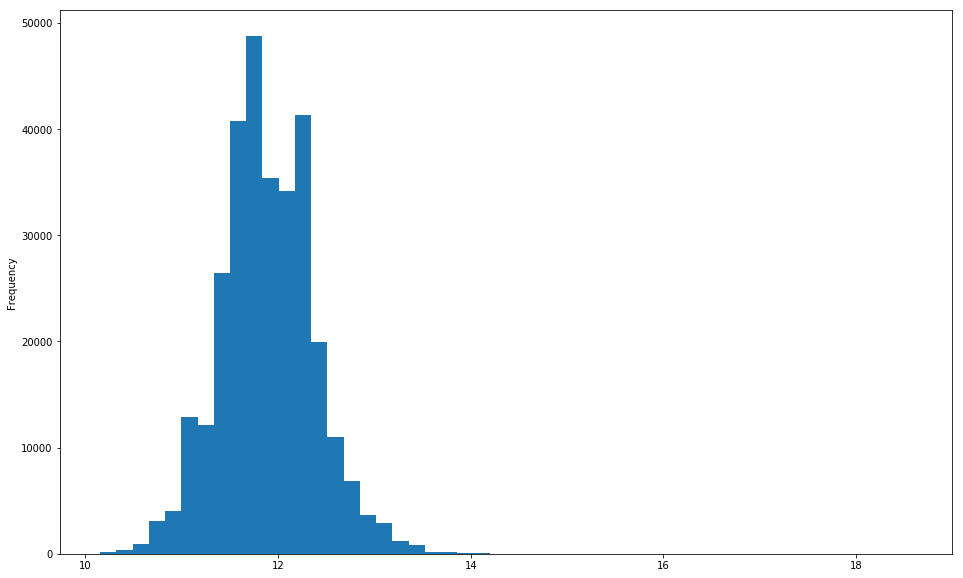

In [91]:
transform(sTest).plot(kind = 'hist', bins = 50, figsize = (16,10))

In [186]:
numbers = [1,2,3,10]
compare = [0,3,4,5]

In [189]:
[np.log1p(X) if X<pvalues else X for X, pvalues in zip(numbers, compare)]

[1, 1.0986122886681096, 1.3862943611198906, 10]

In [187]:
zip(numbers, compare)

In [188]:
for x, y in zip(numbers, compare):
    print(x,y)

1 0
2 3
3 4
10 5
